# **CAPSTONE PROJECT WASTE PREDICTION**

## **1. Import Library yang Dibutuhkan**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plt_image
import matplotlib.image as mpimg

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import TensorBoard
%reload_ext tensorboard
%matplotlib inline

from google.colab import files
from keras.preprocessing import image
import zipfile,os

## **2. Mengunduh Zipfile Waste Classification data dari kaggle**

In [ ]:
# install kaggle
! pip install -q kaggle

from google.colab import files
files.upload()

# create a kagle folder
! mkdir ~/.kaggle

# copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

# permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

# to list all datasets in kaggle
! kaggle datasets list

! kaggle datasets download -d techsash/waste-classification-data

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          17970  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          10700  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5333  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3840  
promptcloud/careerbuilder-job-listing-2020

## **3. Extract Dataset berbentuk Zipfile**

In [ ]:
local_zip = '/content/waste-classification-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/waste')
zip_ref.close()

Cek Folder yang terdapat pada Dataset

In [ ]:
os.listdir('/tmp/waste/')

['dataset', 'DATASET']

## **4. Overview Gambar**

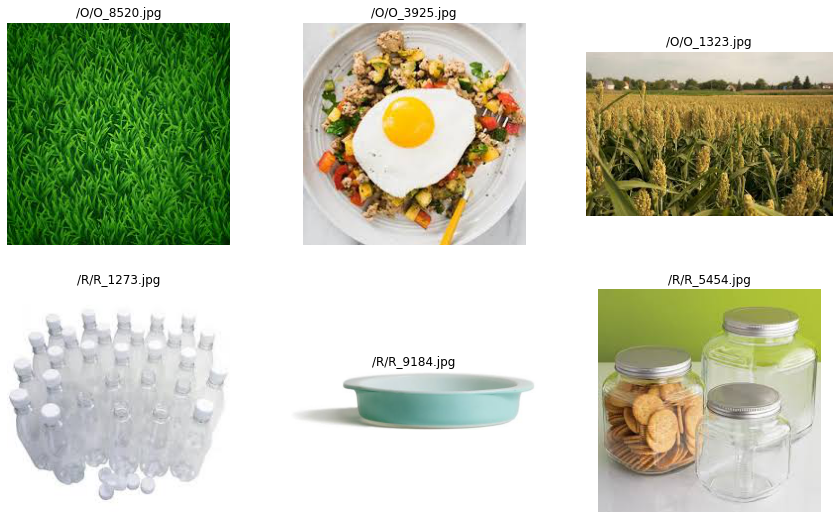

In [ ]:
TOTAL = 3                        # Total Menampilkan Gambar
index = np.random.randint(10)    # Untuk Mengambil Sampel Acak

plt.figure(figsize=(5*TOTAL, 9))

list_organic = [os.path.join('/tmp/waste/DATASET/TRAIN/O', name) for name in os.listdir('/tmp/waste/DATASET/TRAIN/O')[index:index+TOTAL]]
list_non_organic = [os.path.join('/tmp/waste/DATASET/TRAIN/R', name) for name in os.listdir('/tmp/waste/DATASET/TRAIN/R')[index:index+TOTAL]]

for i, path in enumerate(list_organic+list_non_organic):
  plt.subplot(2, TOTAL, i+1)
  plt.axis('off')

  plt.title(path.replace('/tmp/waste/DATASET/TRAIN', ''))
  img = plt_image.imread(path)
  plt.imshow(img)

Dapat dilihat bahwa pada overview gambar menampilkan beragam gambar jenis sampah organik dan non-organik

SAMPAH ORGANIK


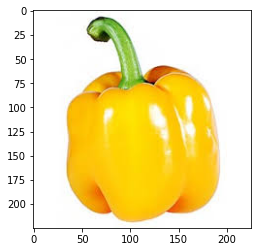

(225, 225, 3)


In [ ]:
print('SAMPAH ORGANIK')
preview = plt_image.imread('/tmp/waste/DATASET/TRAIN/O/O_1842.jpg')
plt.imshow(preview)
plt.show()
print(preview.shape)

SAMPAH NON-ORGANIK


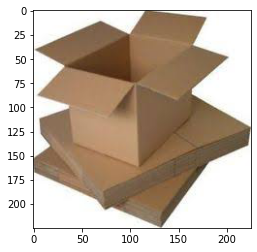

(225, 225, 3)


In [ ]:
print('SAMPAH NON-ORGANIK')
preview = plt_image.imread('/tmp/waste/DATASET/TRAIN/R/R_2261.jpg')
plt.imshow(preview)
plt.show()
print(preview.shape)

Dari overview gambar diatas dapat diketahui bahwa ukuran gambar dataset ini adalah 225x225 dengan color profile RGB (3) nantinya ukuran ini akan berguna untuk menentukan target size yang dibutuhkan

## **5. Membuat Direktori Baru untuk Train dan Validation Data**

Karena dalam dataset file gambar sudah terbagi menjadi train dan test, maka kita tinggal menyesuaikan direktorinya

In [ ]:
train_dir = '/tmp/waste/DATASET/TRAIN/'
validation_dir = '/tmp/waste/DATASET/TEST/'

In [ ]:
# melihat struktur data
os.listdir('/tmp/waste/DATASET/TRAIN/')
os.listdir('/tmp/waste/DATASET/TEST/')

['R', 'O']

Dibawah ini menampilkan banyaknya jumlah file pada tiap direktori train dan validation pada masing-masing organic dan non-organic

In [ ]:
print('Banyaknya Data Train\nOrganic : ')
print(len(os.listdir('/tmp/waste/DATASET/TRAIN/O')))
print('Non-organic : ')
print(len(os.listdir('/tmp/waste/DATASET/TRAIN/R')))

print('\nBanyaknya Data Validation\nOrganic : ')
print(len(os.listdir('/tmp/waste/DATASET/TEST/O')))
print('Non-organic : ')
print(len(os.listdir('/tmp/waste/DATASET/TEST/R')))

Banyaknya Data Train
Organic : 
12565
Non-organic : 
9999

Banyaknya Data Validation
Organic : 
1401
Non-organic : 
1112


## **6. Image Preprocessing**

**Augmentasi Gambar** menggunakan Image Data Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

Menggunakan objek Image Data Generator sebelumnya untuk mempersiapkan data latih yang akan dipelajari oleh model

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (225,225),
    batch_size = 64,
    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (225,225),
    batch_size = 64,
    class_mode = 'binary')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


## **7. Membangun Model dengan Arsitektur CNN**

In [ ]:
# Menginisialisasi Callback
class stopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > 0.81) and (logs.get('val_accuracy') > 0.81)):
      print("\nStop Training because the accuracy and val_accuracy has exceeded 80%")
      self.model.stop_training = True

model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(128,(3,3), activation='relu', input_shape=(225,225,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(16,(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1024, activation='relu'),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')])

Memanggil fungsi **compile** pada objek, dan tentukan **loss function** serta **optimizer**

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 223, 223, 128)     3584      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 52, 52, 32)        18464     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 26, 26, 32)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Melatih model menggunakan metode fit

In [ ]:
history = model.fit(
    train_generator,
    epochs = 20,
    steps_per_epoch = 20,
    validation_data = validation_generator,
    validation_steps = 5,
    verbose=2,
    callbacks=[stopTraining()])

Epoch 1/20
20/20 - 22s - loss: 0.6296 - accuracy: 0.6648 - val_loss: 0.4671 - val_accuracy: 0.8281 - 22s/epoch - 1s/step
Epoch 2/20
20/20 - 21s - loss: 0.5070 - accuracy: 0.7523 - val_loss: 0.4686 - val_accuracy: 0.7969 - 21s/epoch - 1s/step
Epoch 3/20
20/20 - 21s - loss: 0.4883 - accuracy: 0.7664 - val_loss: 0.3778 - val_accuracy: 0.8813 - 21s/epoch - 1s/step
Epoch 4/20
20/20 - 21s - loss: 0.5259 - accuracy: 0.7398 - val_loss: 0.3898 - val_accuracy: 0.8687 - 21s/epoch - 1s/step
Epoch 5/20
20/20 - 21s - loss: 0.4675 - accuracy: 0.7750 - val_loss: 0.3707 - val_accuracy: 0.8687 - 21s/epoch - 1s/step
Epoch 6/20
20/20 - 22s - loss: 0.4889 - accuracy: 0.7700 - val_loss: 0.5050 - val_accuracy: 0.7781 - 22s/epoch - 1s/step
Epoch 7/20
20/20 - 21s - loss: 0.4405 - accuracy: 0.8047 - val_loss: 0.3534 - val_accuracy: 0.8875 - 21s/epoch - 1s/step
Epoch 8/20
20/20 - 20s - loss: 0.4369 - accuracy: 0.8031 - val_loss: 0.3755 - val_accuracy: 0.8656 - 20s/epoch - 1s/step
Epoch 9/20
20/20 - 20s - loss: 0

Model berhasil mencapai accuracy > 80% dan val_accuracy > 80%. Dengan menggunakan callback maka model akan berhenti ketika accuracy dan val_accuracy telah mencapai > 80% dan tidak menunggu sampai epoch selesai. Proses ini memakan waktu sekitar 2 menit, waktu yang dibutuhkan untuk target size gambar sebesar (225,225)

## **8. Membuat Visualisasi Grafik Data Akurasi dan Loss**

Plot Akurasi Model

<function matplotlib.pyplot.show>

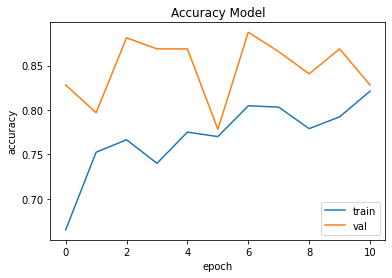

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show

Plot Loss Model

<function matplotlib.pyplot.show>

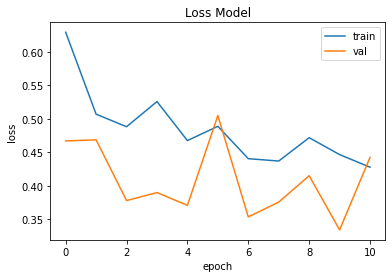

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show

Dari grafik accuracy dan loss tersebut dapat terlihat bahwa prediksi model masih belum stabil.

## **9. Memprediksi Gambar yang Diunggah**

Saving sampah organik5.jpg to sampah organik5 (3).jpg
sampah organik5.jpg
SAMPAH ORGANIK


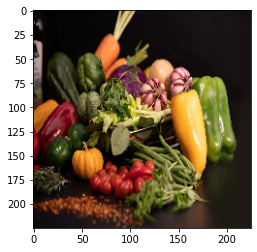

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  # predicting image
  path = fn
  img = image.load_img(path, target_size=(225,225))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes==0:
    print('SAMPAH ORGANIK')
  else:
    print('SAMPAH NON ORGANIK')

Dari hasil prediksi tersebut dapat disimpulkan bahwa prediksi model cukup akurat untuk mengetahui bahwa gambar tersebut adalah sampah organik atau non-organik, selain itu saya juga sudah mencoba dengan beberapa gambar lain dan hasilnya sudah cocok semua.

## **10. Konversi Model kedalam file.json**

From Keras to Javascript

In [ ]:
! pip install tensorflowjs

# Convert to .h5
model.save("model.h5")

# Convert to tf.js
! tensorflowjs_converter --input_format keras --output_format=tfjs_graph_model /content/model.h5 /content/json/

     |████████████████████████████████| 77 kB 3.1 MB/s 
2021-12-17 15:34:56.409540: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-12-17 15:34:57.147042: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Writing weight file /content/json/model.json...


In [ ]:
import pickle